# Embedding Trainer
---
Main script to train our various embedding models. What we'll do is import our 'Embedding Model' objects that we'll define in other files - and this code will be the training loop and will save the results to various folders.

## Create our Dataloader and Tokenizer
---
We already defined these and trained the tokenizer in the other files. So, let's go ahead and instantiate these as a first step

### Import Dependencies

In [7]:
# First - need to import sys and os and nav to our project_root
import sys
import os
import datetime

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Now import our dependencies
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from dataloader.dataloader import MyDataLoader
from tokenizer.tokenizer import MyTokenizer

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Instantiate our Dataloader

In [9]:
dl = MyDataLoader(
    promptuser=False, 
    batch_size=1, 
    shuffle=True)    
# By setting promptuser=False, we just use the 'enwiki_articles_20240320_mini' dataset (50MB)

train_dataloader = dl.get_train_dataloader()
test_dataloader = dl.get_test_dataloader()

for batch in train_dataloader:
    sample_data = batch[0][0]
    break
for batch in test_dataloader:
    sample_testdata = batch[0][0]
    break


print(f"Train Data:\nNumber of chars: {len(sample_data)}\n{'='*60}")
print(sample_data[:100])
print(f"\n\nTest Data:\nNumber of chars: {len(sample_testdata)}\n{'='*60}")
print(sample_testdata[:100])

Train Data:
Number of chars: 15234
<h2>APPENDIX A COMMON ABBREVIATIONS</h2>

<h2>APPENDIX B TABLE OF NAMES</h2>
<h3> U.S. OFFICIALS </h


Test Data:
Number of chars: 2376
know now for ourselves,” and, like the Queen of Sheba, said 
“The half was not told.” 

My dear sist


### Instantiate our Tokenizer

In [11]:
tokenizer = MyTokenizer()
tk_vocab_size = tokenizer.get_vocab_size()

# Ensure our tokenizer is running properly
chars_to_print = 100
print(tokenizer.encode_as_ids(sample_data[:chars_to_print]))
print(f"{'-'*60}")
print(tokenizer.encode_as_pieces(sample_data[:chars_to_print]))
print(f"{'-'*60}")
print(tokenizer.decode(tokenizer.encode_as_ids(sample_data[:chars_to_print])))

[349, 15929, 396, 7254, 15961, 15022, 15946, 0, 57, 4266, 1720, 57, 15958, 15958, 4937, 15997, 1750, 9423, 15949, 313, 15929, 396, 349, 15929, 396, 7254, 15961, 15022, 15946, 0, 122, 62, 15947, 15958, 4137, 4229, 198, 8315, 2188, 313, 15929, 396, 349, 15929, 506, 296, 15944, 15949, 15944, 4229, 15972, 2396, 11782, 15949, 2416, 15929]
------------------------------------------------------------
['▁<', 'h', '2>', 'AP', 'P', 'END', 'I', 'X', '▁A', '▁COMM', 'ON', '▁A', 'B', 'B', 'RE', 'V', 'IA', 'TION', 'S', '</', 'h', '2>', '▁<', 'h', '2>', 'AP', 'P', 'END', 'I', 'X', '▁B', '▁T', 'A', 'B', 'LE', '▁OF', '▁N', 'AM', 'ES', '</', 'h', '2>', '▁<', 'h', '3>', '▁U', '.', 'S', '.', '▁OF', 'F', 'IC', 'IAL', 'S', '▁</', 'h']
------------------------------------------------------------
<h2>APPENDI ⁇  A COMMON ABBREVIATIONS</h2> <h2>APPENDI ⁇  B TABLE OF NAMES</h2> <h3> U.S. OFFICIALS </h


## Define our Helper Functions

In [16]:
def _yield_CBOW_batch(text, n_window, batch_size=8, util_rate=0.5, spec_iter=None, vocab_size=tk_vocab_size, device=device, tokenizer=tokenizer):
    """
        Generator function that takes in text and returns a number of batches for each dataset based on the utilization rate specified. To be used in a CBOW model.

        Inputs:
            text:       (string) The text provided by the dataloader
            n_window:   (int) Size of our context window for the CBOW model. I.e., if n_window=4, then we will use the left 4 words and right 4 words to predict our target word
            batch_size: (int) Number of samples to return in each batch
            util_rate:  (float) Value from (0, 1] that specifies the % of possible batches that are generated before moving to next sample
            spec_iter:  (int) If set to none, we use util rate to determine num batches from this data. If set to an int, we use that number.
            vocab_size: (int) size of our tokenizer vocabulary
            device:     Pytorch device (e.g., cuda / cpu)
            tokenizer:  Our defined tokenizer (above). encode_as_ids(text) returns a 1-D python list of tokens

        Yields (generator function) batches of data in the form of GPU-mounted pytorch tensors until util_rate is tripped.
    """
    # Tokenize our data and determine number of batches we'll use
    tokens = torch.tensor(tokenizer.encode_as_ids(text), dtype=torch.int, device=device)
    len_tokens = len(tokens)
    num_possible_pairs = len_tokens - (2 * n_window)
    num_batches = int((num_possible_pairs * util_rate) // batch_size) if spec_iter==None else min(spec_iter, int(num_possible_pairs // batch_size))

    # Get random permutation of the possible 'center indices' --> these become our targets and surrounding 'n_window' size is our context
    center_indices = torch.arange(n_window, len_tokens - n_window, device=device).int()
    center_indices = center_indices[torch.randperm(center_indices.size(0))][:num_batches*batch_size]

    # Generate # of batches for this dataset
    for i in range(num_batches):
        batch_center_indices = center_indices[i*batch_size:(i+1)*batch_size]
        context_indices_list = []
        target_indices_list = []
        
        for center_idx in batch_center_indices:
            # Create a context window around the center word
            context_window = tokens[(center_idx - n_window):(center_idx + n_window + 1)]
            context_indices = torch.cat((context_window[:n_window], context_window[n_window+1:]))
            target_index = tokens[center_idx]
            
            context_indices_list.append(context_indices)
            target_indices_list.append(target_index)
        
        # Stack lists to create batch tensors
        context_tensor = torch.stack(context_indices_list).to(device)
        target_tensor = torch.stack(target_indices_list).to(device)
        
        yield context_tensor, target_tensor

for batch, (context, target) in enumerate(_yield_CBOW_batch(sample_data, n_window=4)):
    print(f"Batch {batch+1}")
    print(f"{'-'*60}")
    print(context)
    print(target)
    break

Batch 1
------------------------------------------------------------
tensor([[15941, 14108, 11912,  1817,  1051, 15947, 15943,  2472],
        [ 3004,   183, 15962, 15963, 15944, 15992,  2630,  7625],
        [ 2068,    88,     6,  9439,   934,  5238, 15921,     0],
        [15941,  7054,    43,  8698,   143, 15939,   124,   379],
        [  103,   191,    26, 15506,   480, 15931, 15941,   124],
        [15947,   709, 15941,   348,   223,   157, 15209, 15921],
        [11136,  4085, 15941,  2004, 15941,  2555,  9085,  5816],
        [   16,  2355,  2068,  3519,   523,    43,     7, 11127]],
       device='cuda:0', dtype=torch.int32)
tensor([ 5816, 15970,   134,   227, 15940,  9530, 15398, 15939],
       device='cuda:0', dtype=torch.int32)


In [44]:
# Next - let's keep track of our loss data
def _estimate_loss(model, n_window, batching_fn, train_dl, test_dl, n_samples=10, iters_per_sample=10, device=device):
    """
        Function to estimate our loss (train and test) that we can call

        Inputs:
            model:             Pytorch sequential model
            n_window:          (int) Specify size of window to test over (for our CBOW / Skipgram models)
            batching_fn:       Function that returns our data as (context, targets)
            train_dl:          Pytorch dataloader for train data
            test_dl:           Pytorch dataloader for test data
            n_samples:         (int) Specify number of iterations to compute loss over
            iters_per_sample:  (int) Specify number of iterations per sample to compute loss over
            device:            Pytorch device (cuda / cpu)

        Returns the mean train loss and the test loss over n_iters samples
    """
    train_loss = torch.zeros(n_samples*iters_per_sample, device=device)
    test_loss = torch.zeros(n_samples*iters_per_sample, device=device)

    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(train_dl):
            for (context, targets) in batching_fn(sample[0][0], n_window, spec_iter=iters_per_sample):
                loss = model(context, targets)
                train_loss[i-1] += loss
            if i == n_samples:
                break
        for i, sample in enumerate(test_dl):
            for (context, targets) in batching_fn(sample[0][0], n_window, spec_iter=iters_per_sample):
                loss = model(context, targets)
                test_loss[i-1] += loss
            if i == n_samples:
                break

    model.train()
    return train_loss.mean(), test_loss.mean()

## Import and Train our Model

In [45]:
# Continuous Bag of Words model for training embeddings as specified in Word2Vec (https://arxiv.org/pdf/1301.3781.pdf)
class CBOW_NegativeSampling(nn.Module):
    def __init__(self, embed_dim, effic_strat=None, vocab_size=tk_vocab_size, device=device):
        """
        Inputs:
            embed_dim:   (int) number of dimensions for our embeddings
            effic_strat: (str) either 'neg-sample' or 'hier-softmax' - used to define which strategy for efficient computation to use
            vocab_size:  (int) the size of the vocabulary
            device:      Pytorch device (cuda / cpu)
        """
        super().__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, embed_dim).to(device)
        self.initialize_embeddings()

    def initialize_embeddings(self):
        """ Initializes the embedding weights to a normal distribution with mean 0 and a specified variance """
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=1)

    def forward(self, context_indices, positive_indices, num_negative_samples=5):
        """
            Performs a forward pass with negative sampling.
            
            Parameters:
            - context_indices: Indices of the context words [B, Context_size].
            - positive_indices: Indices of the target (positive) words [B, 1].
            - num_negative_samples: Number of negative samples per positive sample.
        """
        batch_size = context_indices.size(0)
        context_embeds = self.embeddings(context_indices).mean(dim=1, keepdims=True)  # [B, context_size, embed_dim] --> [B x 1 x embed_dim]
    
        # Embedding lookup for positive samples
        positive_embeds = self.embeddings(positive_indices).unsqueeze(-1)  # [B, embed_dim, 1]
    
        # Generating negative samples
        # Note: For simplicity, this samples uniformly from the vocabulary.
        # Consider using a distribution that matches word frequencies for better performance.
        negative_indices = torch.randint(0, self.vocab_size, (batch_size, num_negative_samples), device=self.device)
        negative_embeds = self.embeddings(negative_indices).transpose(1,2)  # [B, embed_dim, num_negative_samples]
    
        # Compute logits
        positive_logits = torch.bmm(context_embeds, positive_embeds).squeeze()      # [B x 1 x embed_dim] @ [B, embed_dim, 1] -> [B, 1, 1] -> [B]
        negative_logits = torch.bmm(context_embeds, negative_embeds).squeeze()      # [B, num_negative_samples]
    
        # Labels: 1s for positive, 0s for negative
        positive_labels = torch.ones_like(positive_logits)
        negative_labels = torch.zeros_like(negative_logits)
    
        # Loss: binary cross-entropy with logits
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, positive_labels)
        negative_loss = F.binary_cross_entropy_with_logits(negative_logits, negative_labels)
        loss = positive_loss + negative_loss.mean()
        return loss

    def find_closest_embeddings(self, input_embedding, n=5):
        """
            Find the n embeddings in the model that have the largest cosine similarity
            to the given input_embedding.
    
            Inputs:
                input_embedding (Tensor): The input embedding vector.
                n (int): The number of closest embeddings to return.
    
            Returns a tensor of indices of the n closest embeddings.
        """
        input_embedding_norm = input_embedding / input_embedding.norm()
        all_embeddings = self.embeddings.weight
        similarities = F.cosine_similarity(input_embedding_norm.unsqueeze(0), all_embeddings, dim=1)
        _, closest_indices = torch.topk(similarities, n)
        return closest_indices

    def get_embedding(self, index):
        """ Retrieve the vector embedding corresponding to a given index Returns a tensor of the embedding vector """
        return self.embeddings.weight[index]

    def save_weights(self, filename):
        """ Save the model weights to a file """
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        """ Load the model weights from a file. Ex. 'trained_models/mymodel.pth' """
        self.load_state_dict(torch.load(filename, map_location=self.device))
        print(f"Model weights loaded from {filename}")

In [46]:
# Define a simple training loop
def train_model(embedding_model, train_dl, test_dl, tokenizer, device, embed_dim, learning_rate, epochs, max_iters, print_freq=2000, saveweights=True):
    """
    Main training loop for the model specified in 'embedding_model'.
    
    Parameters:
    - embedding_model: The key to the embedding model configuration.
    - train_dl: Training DataLoader.
    - test_dl: Testing DataLoader.
    - tokenizer: Tokenizer used for encoding text.
    - device: The device (cuda/cpu) on which to train the model.
    - epochs: Number of epochs to train for.
    - saveweights: Whether to save the model weights.
    - embed_dim: Dimensionality of the embeddings.
    - learning_rate: Learning rate for the optimizer.
    """
    modelclass = emb_model[embedding_model]["modelclass"]
    n_window = emb_model[embedding_model]["n_window"]
    batching_fn = emb_model[embedding_model]["batching_fn"]
    
    model = modelclass(embed_dim=embed_dim, device=device)
    model.to(device)
    print(f"Using device: {device}")
    print(f"{(sum(p.numel() for p in model.parameters())/1e6):.3f}M parameters")
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = torch.zeros(int(max_iters//print_freq), 3, device=device)
    iter = 0
    
    for _ in range(epochs):
        for sample in train_dl:
            for (context, targets) in batching_fn(sample[0][0], n_window):
                iter += 1
                loss = model(context, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if iter % print_freq == 0:
                    train_loss, test_loss = _estimate_loss(model, n_window, batching_fn, train_dl, test_dl, n_samples=5, iters_per_sample=10, device=device)
                    print(f"{iter}/{int(max_iters)}: Train loss = {train_loss:.3f}; Test loss = {test_loss:.3f}")
                    
                    print_idx = iter//print_freq - 1
                    losses[print_idx] = torch.tensor([iter, train_loss, test_loss], device=device)
                
                if iter >= max_iters:
                    break    
            if iter >= max_iters:
                break
        if iter >= max_iters:
            break
    
    # Ensure directories exist
    if not os.path.exists('trained_models'):
        os.makedirs('trained_models')
    if not os.path.exists('loss_results'):
        os.makedirs('loss_results')
    
    # Save model and losses
    datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_prefix = f"{embedding_model}-{tokenizer.get_vocab_size()//1000}k-{datetime_str}"
    weights_path = os.path.join('trained_models', file_prefix + '.pth')
    model.save_weights(weights_path)
    print(f"Model weights saved to {weights_path}")
    
    losses_df = pd.DataFrame(losses.cpu().numpy(), columns=['Iteration', 'Train Loss', 'Test Loss'])
    csv_path = os.path.join('loss_results', file_prefix + '.csv')
    losses_df.to_csv(csv_path, index=False)
    print(f"Loss data saved to {csv_path}")

In [47]:
# Defining our different embedding models
emb_model = {
    "CBOW-5-NS": {"modelclass": CBOW_NegativeSampling, "batching_fn": _yield_CBOW_batch, "n_window": 5},
    "CBOW-5-HS": {"modelclass": TBD, "batching_fn": _yield_CBOW_batch, "n_window": 5},
    "Ngram-5-NS": {"modelclass": TBD, "batching_fn": "TBD", "n_window": 5},
    "Ngram-5-HS": {"modelclass": TBD, "batching_fn": "TBD", "n_window": 5},
 }

# Training specific hyperparams
embedding_model = "CBOW-5-NS"
learning_rate = 3e-4
embed_dim = 128
epochs = 50

# Training our model
loss = train_model(embedding_model=embedding_model, 
                   train_dl=train_dataloader, 
                   test_dl=test_dataloader, 
                   tokenizer=tokenizer, 
                   device=device, 
                   embed_dim=embed_dim, 
                   learning_rate=learning_rate, 
                   epochs=epochs,
                   max_iters=2e5,
                   print_freq=200)

Using device: cuda
2.048M parameters
200/200000: Train loss = 3.580; Test loss = 3.860
400/200000: Train loss = 3.877; Test loss = 3.754
600/200000: Train loss = 3.667; Test loss = 3.875
800/200000: Train loss = 3.728; Test loss = 3.733
1000/200000: Train loss = 3.620; Test loss = 3.798
1200/200000: Train loss = 3.943; Test loss = 3.667
1400/200000: Train loss = 3.509; Test loss = 3.511
1600/200000: Train loss = 3.578; Test loss = 3.780
1800/200000: Train loss = 3.643; Test loss = 3.599
2000/200000: Train loss = 3.628; Test loss = 3.653
2200/200000: Train loss = 3.589; Test loss = 3.515
2400/200000: Train loss = 3.564; Test loss = 3.630
2600/200000: Train loss = 3.597; Test loss = 3.663
2800/200000: Train loss = 3.419; Test loss = 3.499


KeyboardInterrupt: 

## Plotting Loss and Testing our Trained Models
---

In [48]:
import matplotlib.pyplot as plt

In [49]:
def visualize_loss(filename):
    # Load the CSV file
    df = pd.read_csv(os.path.join('loss_results', filename))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Iteration'], df['Train Loss'], color='blue', label='Train Loss', s=10)  # Adjusted size here
    plt.scatter(df['Iteration'], df['Test Loss'], color='orange', label='Test Loss', s=10)  # And here
    plt.title('Training and Test Loss Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

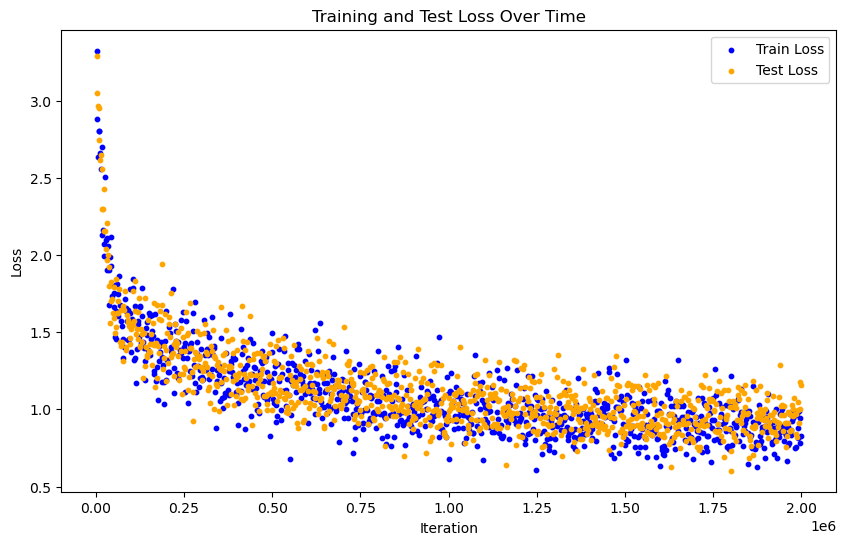

In [50]:
visualize_loss("CBOW-5-NS-16k-2024-03-29_23-17.csv")

In [51]:
# Now - let's see what we can get from the embedding model for various word arithmetic tests
embedding_model = "CBOW-5-NS"
mymodel = CBOW_NegativeSampling(embed_dim=128)
mymodel.load_weights("trained_models/CBOW-5-NS-16k-2024-03-29_23-17.pth")

Model weights loaded from trained_models/CBOW-5-NS-16k-2024-03-29_23-17.pth


In [52]:
def print_closest_ids(string):
    tok = tokenizer.encode_as_ids(string)
    tok_text = tokenizer.encode_as_pieces(string)
    if len(tok)>1:
        print("Try new token - token length > 1")
        return

    token_embedding = mymodel.get_embedding(tok)
    closest_ids = mymodel.find_closest_embeddings(token_embedding, n=5)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: {string}\nToken: {tok} - {tok_text}\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        print(f"Id: {i} - {tokenizer.decode(id)}")

# Testing
test_word = "teeth"
print_closest_ids(test_word)

Closest tokens for: teeth
Token: [6825] - ['▁teeth']
------------------------------------------------------------
Id: 0 - S
Id: 1 - ir
Id: 2 - as
Id: 3 - The
Id: 4 - su


In [53]:
# Defining a - b + c = ?
def closest_five_arith(a, b, c):
    
    tok_a = tokenizer.encode_as_ids(a)
    tok_b = tokenizer.encode_as_ids(b)
    tok_c = tokenizer.encode_as_ids(c)
    
    if (len(tok_a) + len(tok_b) + len(tok_c)) > 3:
        print("Words not single tokens")
        return
    
    emb_a = mymodel.get_embedding(tok_a)
    emb_b = mymodel.get_embedding(tok_b)
    emb_c = mymodel.get_embedding(tok_c)

    new_emb = emb_a - emb_b + emb_c
    closest_ids = mymodel.find_closest_embeddings(new_emb, n=5)
    closest_ids = (closest_ids.to('cpu')).flatten().tolist()
    print(f"Closest tokens for: '{a}' - '{b}' + '{c}'\n{'-'*60}")
    for i, id in enumerate(closest_ids):
        print(f"Id: {i} - {tokenizer.decode(id)}")

a = "hands"
b = "hand"
c = "leg"
closest_five_arith(a, b, c)

Closest tokens for: 'hands' - 'hand' + 'leg'
------------------------------------------------------------
Id: 0 - su
Id: 1 - ter
Id: 2 - ou
Id: 3 - ch
Id: 4 - od
